## Bayes Classifier for Cifar-10:
The two variant of Naives Bayes Classifier are developed from scratch by using color-channels as feature vector:
1. Naive bayes : Considering multiple -1d  Gaussian  distribution
2. Multi-Variate Gaussian Bayes Classifier : Considering  Multi-variate_normal distribution.
Dataset Link: https://www.cs.toronto.edu/~kriz/cifar.html


In [1]:
# Import libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pickle
import glob
import time
from random import random
from collections import defaultdict
from skimage.transform import rescale, resize

In [2]:
# Function to Load images
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

In [3]:
# Function to calcualte acuuracy
def class_acc(x, y):
    """
    Find accuracy percentage of given predicted and true labels.
    Parameters
    ----------
    x (ndarray): True label
    y (ndarray): Predicted label
    Return
    ------
    accuracy: Accuracy percentage
    """

    if len(x) == len(y):
        accuracy = (np.sum(x == y) / len(x)) * 100
        return np.round(accuracy, decimals=2)
    else:
        print('Predicted and Ground truth must have same length')



In [4]:
# Change image size to given scale  or  average the color channels
def cifar10_color(data, im_rescale=None):
    """
    This function do 2 following things:
     1.Convert an image of(n , 32, 32,3) into given size, and flatten them.
     2.Average color channels for feature vectors
    :param
    data(ndarray): Image data
    :return(ndarray):
    Resized image  size
    """
    if im_rescale:
        resized_img_array = np.zeros((data.shape[0], im_rescale * im_rescale * 3))  # store resized image array
        for i in range(data.shape[0]):  # loop through each image
            img_1x1 = resize(data[i], (im_rescale, im_rescale))  # resize (32,32) to (im_rescale,im_rescale)
            resized_img_array[i, :] = img_1x1.flatten()
    else:
        resized_img_array = np.zeros((data.shape[0],  3))  # store average image-channels(RGB)
        for i in range(data.shape[0]):  # loop through each image
            im_red = data[i][:,:,0].mean() # red color average
            im_blue = data[i][:,:,1].mean()  # blue color average
            im_green = data[i][:,:,2].mean()  # green color average
            resized_img_array[i, :] = (im_red, im_blue, im_green)

    return resized_img_array

### 1. Naive bayes :
Considering multiple -1d Gaussian distribution

In [5]:
# Find parameters for gaussian distribution of color channels in each class
def cifar10_naivebayes_learn(data, label):
    """
    Calculate  mean, variance, std and prior probability of each color channels in each class in Train dataset.
    :param
    data (ndarray): Resized Train image data i.e.(n x 3) dim
    label(ndarray):  Train labels
    :return:
    parameter(dict): list of mean, variance, std and prior probality
    """

    parameter = defaultdict(list)  # store values
    for cls_id in np.unique(label):  # class id (0,1, ....,9)
        class_index = np.array(np.where(label == cls_id)).flatten()  # class index
        each_class = data[class_index]  # extract each class
        parameter['mean'].append(np.mean(each_class, axis=0))  # mean
        parameter['var'].append(np.var(each_class, axis=0))  # variance
        parameter['std'].append(np.std(each_class, axis=0))  # std
        parameter['prior'].append(class_index.size / data.shape[0])  # prior probability

    return parameter

In [6]:
# Naive Bayes Classifier
def cifar10_classifier_naivebayes(data, mu, sigma, p, n):
    """
    Bayes Classifier  considering with Multiple 1d Gaussian  distrubtion.
    Find  the maxmium posterior probability (predicted class) of given instances.
    :param
    data (nd array): Test data
    mu (ndarray): Mean values of three colors in each class
    sigma (ndarray): Variance of three colors in each class
    p (ndarry): Prior Probability of each class
    n (int): No. of class
    :return:
    predicted_class (ndarray) : Predicted class
    """

    class_prob = []
    # loop through each class
    for c in np.arange(n):
        # pdf of normal distribution (likelihood) from scratch
        ml_r_g_b = 1 / (np.sqrt(2 * np.pi * sigma[c])) * np.exp((-(data - mu[c]) ** 2) / (2 * sigma[c]))
        ml_r_g_b = np.prod(ml_r_g_b, axis=1)  # row-wise product i.e. ml_r * ml_g * ml_b
        prob = p[c] * ml_r_g_b  # posterior prob
        class_prob.append(prob)

        '''
        # pdf of normal distribution (likelihood) from scipy
        ml_r_g_b = scipy.stats.norm(mu[c], sigma[c]).pdf(data) # likelihood
        ml_r_g_b = np.prod(ml_r_g_b, axis=1) # multiply 
        prob = p[c] * ml_r_g_b # posterior porbability
        class_prob.append(prob)
        '''

    cls_pred = np.argmax(np.array(class_prob), axis=0)  # predicted class
    return cls_pred

 ### 2. Bayes Classifier (Multi-Variate Gaussian ) : 
 Considering Multi-variate_normal distribution.

In [7]:
# Find Parameter for Multi-Variate Gaussian Bayes
def cifar10_multinormal_bayes_learn(data, label):
    """
    Calculate  mean, co-variance, and prior probability of each feature colors in each class.
    :param
    data (ndarray): Resized Train Image data
    label(ndarray): Train labels
    :return:
    parameter(dict): list of mean, co-variance, and prior probality
    """

    parameter = defaultdict(list)  # store parameter values
    for cls_id in np.unique(label):  # class id (0,1, ....,9)
        class_index = np.array(np.where(label == cls_id)).flatten()  # class index
        each_class = data[class_index]  # extract each class data
        parameter['mean'].append(np.mean(each_class, axis=0))  # mean
        parameter['cov'].append(np.cov(each_class.T))  # co-variance
        parameter['prior'].append(class_index.size / data.shape[0])  # prior probability

    return parameter

In [8]:
# Multi-Variate Guassian Bayes Classifier
def cifar10_multinormal_naive_bayes(data, mu, cov, p, n):
    """
    Bayes Classifier  considering with one Multivariate_normal distrubtion (one 3d in this case) .
    Find  the maxmium posterior probability (predicted class) of given instances.
    :param
    data (nd array): Test data
    mu (ndarray): Mean values of colors feature in each class
    cov (ndarray): Co-Variance of  colors feature in each class
    p (ndarry): Prior Probability of each class
    n (int): No. of class
    :return:
    predicted_class (ndarray) : Predicted class
    """

    class_prob = []

    # loop through each class
    for c in np.arange(n):
        ml = scipy.stats.multivariate_normal(mu[c], cov[c]).logpdf(data)  # likelihood (pdf)
        prob = p[c] * ml  # posterior prob
        class_prob.append(prob)

    cls_pred = np.array(class_prob)  # change to numpy array
    predicted_class = np.argmax(cls_pred, axis=0)  # predicted  class
    return predicted_class

Test data shape:  (10000, 32, 32, 3)
Test Labels shape:  (10000,)

Train data shape:  (50000, 32, 32, 3)
Train Labels shape:  (50000,)



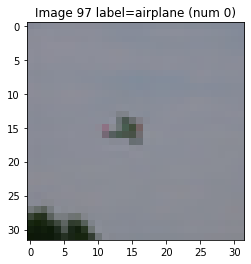

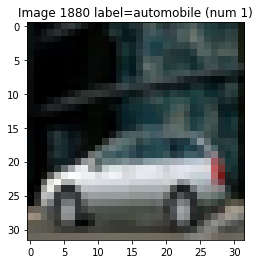

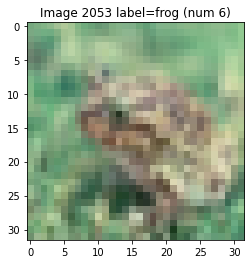

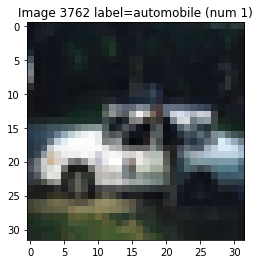

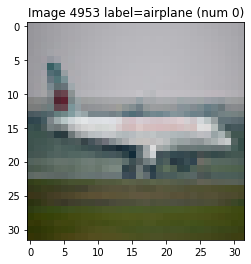

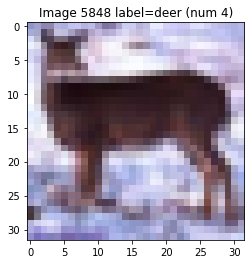

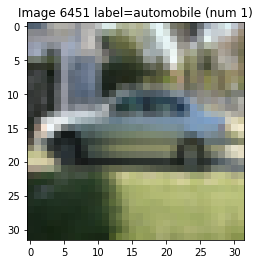

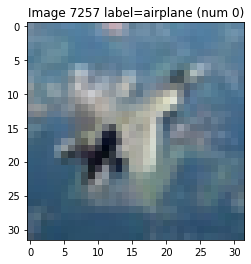

Naive Bayes runinig .... 
(10000, 3)
Accuracy : 19.47 % 

MultiVariate-Gaussain Bayes (Better) running .... 
Accuracy : 24.58 % 

MultiVariate-Gaussain Bayes (Super Powerful)  running .... 
Window-size: (1 x 1)
Accuracy : 24.79 % 

Window-size: (2 x 2)
Accuracy : 31.05 % 

Window-size: (4 x 4)
Accuracy : 40.22 % 

Window-size: (6 x 6)
Accuracy : 41.57 % 

Window-size: (8 x 8)
Accuracy : 41.73 % 

Window-size: (10 x 10)
Accuracy : 42.69 % 

Window-size: (12 x 12)
Accuracy : 42.99 % 

Window-size: (14 x 14)
Accuracy : 42.73 % 

Window-size: (16 x 16)
Accuracy : 43.46 % 

Window-size: (18 x 18)
Accuracy : 42.82 % 

Window-size: (20 x 20)
Accuracy : 43.06 % 

Window-size: (22 x 22)
Accuracy : 43.38 % 

Window-size: (24 x 24)
Accuracy : 42.8 % 

Window-size: (26 x 26)
Accuracy : 41.66 % 

Window-size: (28 x 28)
Accuracy : 40.18 % 

Window-size: (30 x 30)
Error: <class 'numpy.linalg.LinAlgError'> 

Window-size: (32 x 32)
Accuracy : 36.23 % 

Time taken : 1639.9512629508972 seconds


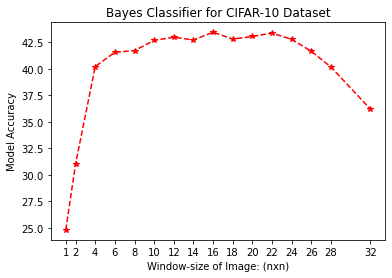

In [9]:
if __name__ == "__main__":

    np.random.seed(100)  # seed random generator

    # Test data
    test_datadict = unpickle('../cifar-10-batches/test_batch')  # change file path
    test_data = test_datadict['data']  # test data
    # test_data = test_data.astype(np.int16)  # change data type

    # Reshape to orignal test image size
    test_data = test_data.reshape(test_data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
    test_labels = np.array(test_datadict['labels'], dtype=np.int16)  # test labels
    print('Test data shape:  {}'.format(test_data.shape))
    print('Test Labels shape:  {}\n'.format(test_labels.shape))

    # Train dataset
    data_batchs = glob.glob('../cifar-10-batches/data_batch*')  # list of data_batches' paths
    train_data = np.empty(shape=[0, 3072], dtype=np.int16)  # empty array for train data
    train_labels = np.empty(shape=[0], dtype=np.int16)  # empty array for train labels

    # Concatenate all Train data_batches
    for batch in data_batchs:
        train_datadict = unpickle(batch)  # unpickle file
        data_batch = train_datadict['data']  # batch data
        train_data = np.vstack((train_data, data_batch))  # stack batches data

        batch_labels = np.array(train_datadict['labels'])  # batch labels
        train_labels = np.hstack((train_labels, batch_labels))  # stack batches labels

    # Reshape to original train image size
    train_data = train_data.reshape(train_data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
    print('Train data shape:  {}'.format(train_data.shape))
    print('Train Labels shape:  {}\n'.format(train_labels.shape))

    # Display random some images
    labeldict = unpickle('../cifar-10-batches/batches.meta')  # change file path
    label_names = labeldict["label_names"]
    # Show some images randomly
    for i in range(test_data.shape[0]):

        if random() > 0.999:
            plt.figure(1)
            plt.clf()
            plt.imshow(test_data[i])
            plt.title(f"Image {i} label={label_names[test_labels[i]]} (num {test_labels[i]})")
            plt.pause(1)

    
    '''=== Naive Bayes classifier: In this case only color-channels(RGB) are taken as feature vecotr with
    assuming independent to each other ==='''
    
    print('Naive Bayes runinig .... ')
    test_img_resized = cifar10_color(test_data)  # resize image to colour channels(RGB) as feature
    train_img_resized = cifar10_color(train_data)
    print(test_img_resized.shape)
    n_parameters = cifar10_naivebayes_learn(train_img_resized, train_labels) # for finding parameters
    prior_prob = n_parameters['prior']  # prior probabilty
    mean = n_parameters['mean']  # mean
    variance = n_parameters['var']  # variance
    # Call Naive Bayes classifer for predciton
    pred_class = cifar10_classifier_naivebayes(test_img_resized, mean, variance, prior_prob, 10)
    accuracy = class_acc(test_labels, pred_class)  # accuracy
    print(f'Accuracy : {accuracy} % \n')


    
    ''' === Multi-Variate Gaussain Bayes classifier (Better): In this case, we consider only color channels(RGB) 
    as feature but taking one Multi-Variate Gaussain(3d) of features. === '''
    
    print('MultiVariate-Gaussain Bayes (Better) running .... ')
    test_img_resized = cifar10_color(test_data)  # resize image to colour channels as feature
    train_img_resized = cifar10_color(train_data)
    parameters_mn = cifar10_multinormal_bayes_learn(train_img_resized, train_labels) # for finding Bayesian parameters
    prior_prob_mn = parameters_mn['prior']  # prior probability
    mean_mn = parameters_mn['mean']  # mean
    cov_mn = parameters_mn['cov']  # co-variance
    # Call classifier for testing
    pred_class_mn = cifar10_multinormal_naive_bayes(test_img_resized, mean_mn, cov_mn, prior_prob_mn, 10)  # classifer
    accuracy_mn = class_acc(test_labels, pred_class_mn)  # accuracy
    print(f'Accuracy : {accuracy_mn} % \n')

    
    
    '''=== MultiVariate Gaussain Bayes Classifier (Super powerful): In this case, we consider features vectors as of
    differnt window-size of an image (for example:1x1, 2x2, ....,32x32) with Multi-Variate Gaussain ==='''
    
    wd_size_range = np.arange(2, 33, 2)  # window size of each colors upto (32 x 32)
    wd_size_range = np.insert(wd_size_range, 0, 1)  # insert 1 at firt positon
    accu_wd_size = []  # store accu of each window_size for plot
    wd_size_rangee = []  # store image wd-size
    print('MultiVariate-Gaussain Bayes (Super Powerful)  running .... ')
    start_time = time.time()  # start time
    for x in wd_size_range:  # loop through window-size

        # Ignore LinAlgError
        try:
            test_img_resized = cifar10_color(test_data, x)  # resize test image
            train_img_resized = cifar10_color(train_data, x)  # resize train image
            print(f'Window-size: ({x} x {x})')

            # call parameters function
            para_wd_size = cifar10_multinormal_bayes_learn(train_img_resized, train_labels)
            mean_wd_size = para_wd_size['mean']  # mean
            cov_wd_size = para_wd_size['cov']  # co-variance
            prior_wd_size = para_wd_size['prior']  # prior prob

            # call classifier
            predicted_wd_size = cifar10_multinormal_naive_bayes(test_img_resized, mean_wd_size, cov_wd_size,
                                                                prior_wd_size, 10)
            accuracy_wd_size = class_acc(test_labels, predicted_wd_size)  # accuracy
            accu_wd_size.append(accuracy_wd_size)
            wd_size_rangee.append(x)
            print(f'Accuracy : {accuracy_wd_size} % \n')
        except Exception as e:
            print(f'Error: {e.__class__} \n')
            pass

    end_time = time.time() - start_time
    print(f'Time taken : {end_time} seconds')
    
    # plot accuracy vs window-size of colours
    fig = plt.figure()
    plt.plot(wd_size_rangee, accu_wd_size, 'r*--')
    plt.title('Bayes Classifier for CIFAR-10 Dataset')
    plt.xlabel('Window-size of Image: (nxn)')
    plt.ylabel('Model Accuracy')
    plt.xticks(wd_size_rangee)
    plt.show()
    